In [ ]:
0.## Kết nối Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
folder = '/content/gdrive/My Drive/KLTN'


Mounted at /content/gdrive


#THƯ VIỆN CẦN THIẾT PHỤC VỤ CHO BÀI TOÁN

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
#Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras. models import Sequential
from keras. layers import Dense
import keras.backend as K
from keras. callbacks import EarlyStopping
from tensorflow.keras import optimizers
from keras.optimizers import Adam
from keras. models import load_model
from keras. layers import LSTM
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

#UPLOAD DATASET



In [ ]:
df=pd.read_csv(folder+ '/Tesla.csv')

#TỔNG QUAN DỮ LIỆU


In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


Bộ dữ liệu bao gồm tổng 1692 dòng và 7 thuộc tính, trong đó có 1 thuộc tính thuộc kiểu dữ liệu định danh, 6 thuộc tính thuộc định lượng. Ngoài ra, không có giá trị null trong bộ dữ liệu này.

In [ ]:
describe_df = df.describe()

def highlight_cells(x):
    mean_color = 'background-color: lightgreen'
    min_color = 'background-color: lightblue'
    max_color = 'background-color: lightcoral'
    volume_color = 'background-color: lightgoldenrodyellow'

    df_styler = pd.DataFrame('', index=x.index, columns=x.columns)

    df_styler.loc['mean', :] = mean_color
    df_styler.loc['min', :] = min_color
    df_styler.loc['max', :] = max_color

    df_styler.loc[:, 'Volume'] = volume_color

    return df_styler

styled_describe_df = describe_df.style.apply(highlight_cells, axis=None)\
                                     .format(precision=2)\
                                     .set_caption('Bảng thống kê mô tả')

styled_describe_df

,Open,High,Low,Close,Volume,Adj Close
count,1692.00,1692.00,1692.00,1692.00,1692.00,1692.00
mean,132.44,134.77,130.00,132.43,4270740.90,132.43
std,94.31,95.69,92.86,94.31,4295971.35,94.31
min,16.14,16.63,14.98,15.80,118500.00,15.80
25%,30.00,30.65,29.21,29.88,1194350.00,29.88
50%,156.33,162.37,153.15,158.16,3180700.00,158.16
75%,220.56,224.10,217.12,220.02,5662100.00,220.02
max,287.67,291.42,280.40,286.04,37163900.00,286.04


- Qua thống kê trên, ta có thể thấy Các giá trị trung bình (mean) của giá Mở cửa (Open), giá Cao (High), giá Thấp (Low), và giá Đóng cửa (Close) lần lượt vào khoảng 132.44, 134.77, 130.00, và 132.43.
- Khối lượng giao dịch trung bình (mean) mỗi ngày được giao dịch khoảng 4.270,740 cổ phiếu, có sự biến động khá lớn và được thể hiện qua độ lệch chuẩn là khoảng 4.295.971 cổ phiếu.
- Các mức phần trăm phân vị cung cấp thêm thông tin về sự phân bố của giá và khối lượng giao dịch, giúp ta hiểu rõ hơn về xu hướng tập trung cũng bộ dữ liệu này.

#TIỀN XỬ LÝ DỮ LIỆU

In [ ]:
#Đổi kiểu dữ liệu của cột 'Date'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', drop = True,inplace = True)

Vì kiểu dữ liệu nguyên bản của cột “Date” trong bộ dữ liệu là Object nhưng để dễ dàng phân tích với dữ liệu thời gian, vì vậy em sẽ tiến hành đổi kiểu sang dạng Datetime.

In [ ]:
#Kiểm tra dữ liệu bị thiếu
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Adj Close,0


Qua kết quả cho thấy, bộ dữ liệu được cập nhật đầy đủ, không bị thiếu.


#PHÂN TÍCH GIÁ CỔ PHIẾU


1. Giá đóng cửa "Close" trung bình hàng tháng


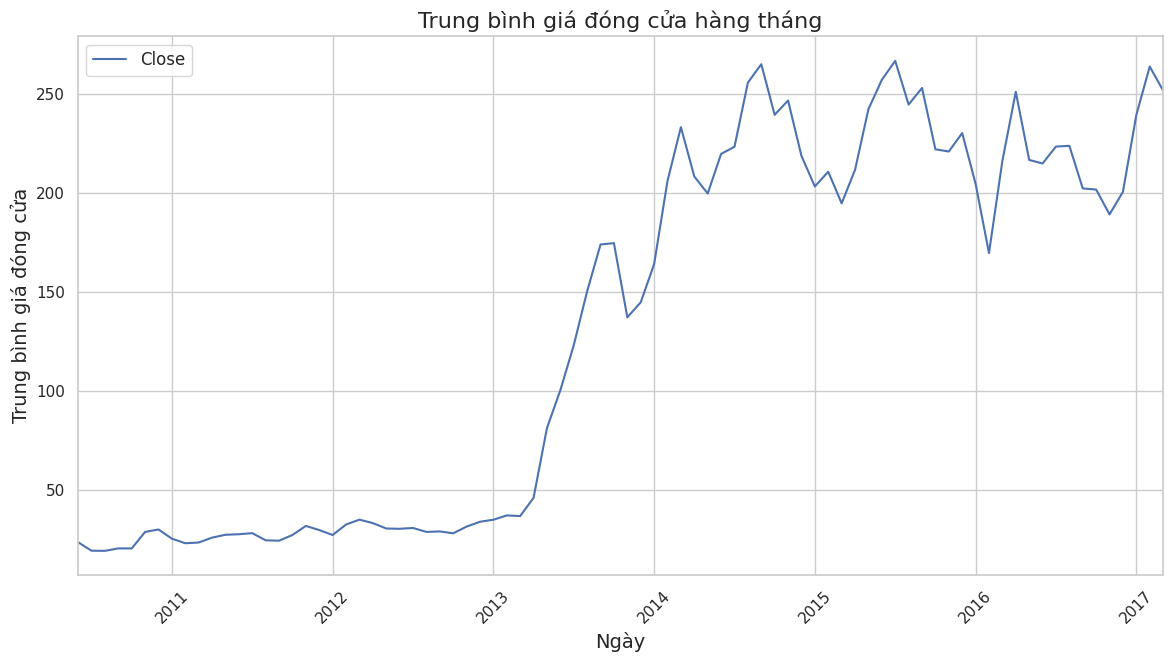

In [ ]:
sns.set(style='whitegrid')

plt.figure(figsize=(14, 7))

ax = df['Close'].resample('ME').mean().plot()

plt.title('Trung bình giá đóng cửa hàng tháng', fontsize=16)
plt.xlabel('Ngày', fontsize=14)
plt.ylabel('Trung bình giá đóng cửa', fontsize=14)

plt.xticks(rotation=45)

plt.grid(True)

plt.legend(['Close'], loc='best', fontsize=12)

plt.gcf().set_facecolor('white')
ax.set_facecolor('white')

plt.show()

- Nhìn chung, giá cổ phiếu được ghi nhận trong khoảng thời gian từ 2011-2017 có xu hướng tăng trưởng. Trong đó, bắt đầu từ khoảng tháng 3/2013 bắt đầu có sự tăng trưởng rõ rệt.
- Bên cạnh đó, ở khoảng thời gian tháng 11/2013 và tháng 2/2016 cũng sụt giảm sâu nhưng vẫn phục hồi mạnh mẽ.


2. Khối lượng giao dịch hằng ngày


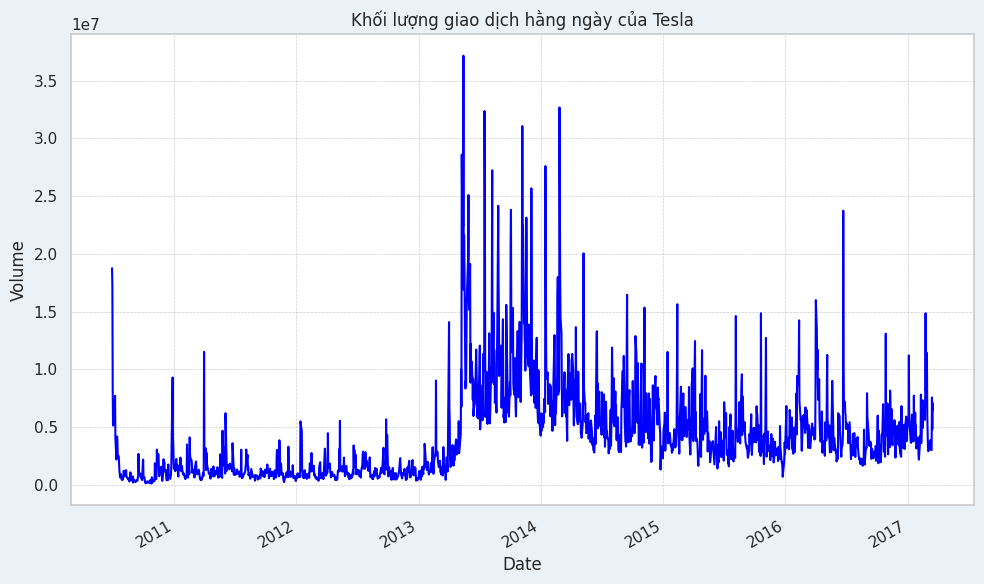

In [ ]:
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ khối lượng giao dịch cho công ty
df['Volume'].plot(color='blue', linewidth=1.5)
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Khối lượng giao dịch hằng ngày của Tesla")

plt.gcf().set_facecolor('#EAF2F8')
plt.grid(visible=True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

- Biểu đồ cho thấy khối lượng giao dịch cổ phiếu Tesla tăng mạnh từ đầu năm 2013 đến 2014, đạt đỉnh gần 3,5 triệu cổ phiếu, có thể do các sự kiện quan trọng của công ty. Nổi bật với các sự kiện như là ra mắt Model S, mở rộng thị trường ra Bắc Mỹ, Châu Á và giới thiệu hệ thống Autopilot vào tháng 10/2014.
- Sau đó, khối lượng giảm nhưng vẫn duy trì ở mức cao hơn so với trước năm 2013. Giai đoạn 2016-2017 cũng có một số đỉnh nhỏ về khối lượng giao dịch. Điều này cho thấy sự gia tăng và duy trì quan tâm của nhà đầu tư đối với cổ phiếu Tesla.

3. TRUNG BÌNH ĐỘNG CHO 10, 20, 50 NGÀY



<Figure size 1200x600 with 0 Axes>

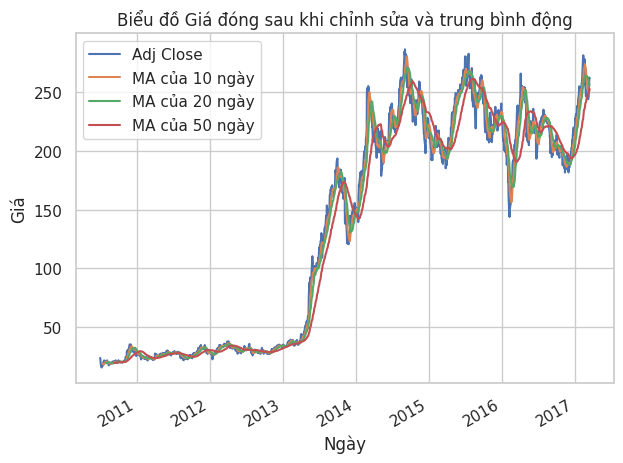

In [ ]:
ma_day = [10, 20, 50]

# Tính toán các đường trung bình động
for ma in ma_day:
    column_name = f"MA của {ma} ngày"
    df[column_name] = df['Adj Close'].rolling(ma).mean()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))

df[['Adj Close', 'MA của 10 ngày', 'MA của 20 ngày', 'MA của 50 ngày']].plot()
plt.title("Biểu đồ Giá đóng sau khi chỉnh sửa và trung bình động")
plt.xlabel("Ngày")
plt.ylabel("Giá")
plt.legend(["Adj Close", "MA của 10 ngày", "MA của 20 ngày", "MA của 50 ngày"])
plt.grid(True)

plt.tight_layout()
plt.show()

- Có thể thấy, giá điều chỉnh “adj close” có sự tăng trưởng mạnh mẽ từ 2013 đến 2014, sau đó có một số giảm nhưng nhìn chung vẫn duy trì xu hướng tăng dài hạn.
- Các đường trung bình động (MA 10, 20, 50 ngày) phản ánh xu hướng ngắn hạn và dài hạn, với MA ngắn hạn (10 ngày) phản ứng nhanh hơn so với MA dài hạn (50 ngày). Xu hướng chính là tăng trưởng dài hạn với những biến động ngắn hạn.

4. LỢI NHUẬN HẰNG NGÀY


In [ ]:
# Tính lợi nhuận hàng ngày cho Tesla
df['Daily Return'] = df['Adj Close'].pct_change()


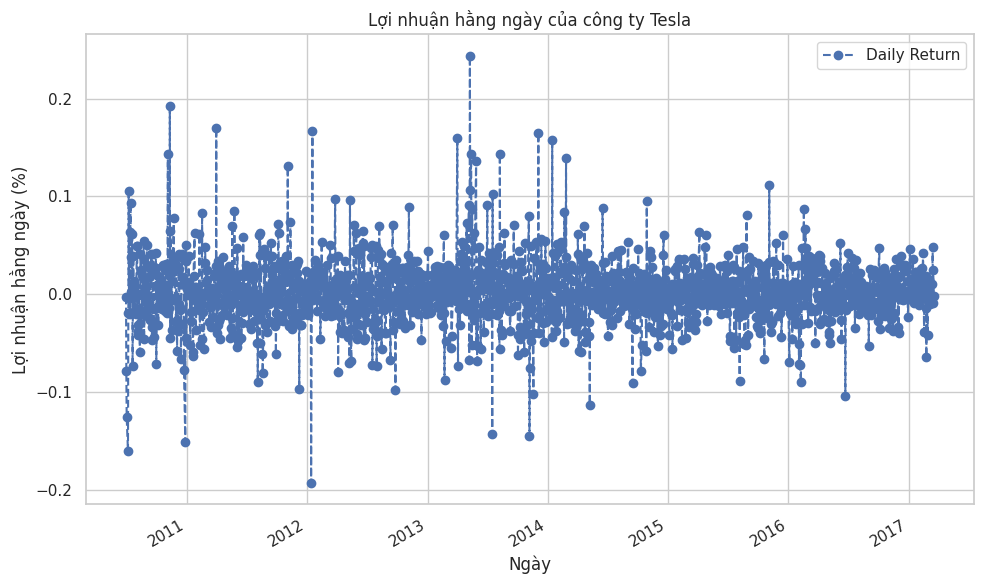

In [ ]:
# Tính lợi nhuận hàng ngày cho Tesla
df['Daily Return'] = df['Adj Close'].pct_change()

# Vẽ biểu đồ lợi nhuận hàng ngày
plt.figure(figsize=(10, 6))
df['Daily Return'].plot(legend=True, linestyle='--', marker='o')
plt.title('Lợi nhuận hằng ngày của công ty Tesla')
plt.xlabel('Ngày')
plt.ylabel('Lợi nhuận hằng ngày (%)')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

- Ở giai đoạn 2010-2013, lợi nhuận của Tesla có sự biến động lớn, các đỉnh và đáy rất rõ rệt. Có những ngày lợi nhuận tăng hoặc giảm đến 20%, nguyên nhân phần lớn đến từ ảnh hưởng bởi các tin tức hoặc sự kiện thị trường khi Tesla vẫn còn đang trong giai đoạn phát triển.
- Sau năm 2013, mức độ biến động giảm dần, cho thấy công ty bắt đầu ổn định hơn. Song song đó, phần lớn các điểm dữ liệu tập trung ở mức 0%, cho thấy rằng lợi nhuận hằng ngày của Tesla thường không quá lớn. Bên cạnh đó, ở khoảng thời gian này vẫn có một số ngày biến động mạnh nằm ngoài phạm vi thông thường (lớn hơn 10%), phản ánh một số rủi ro tồn tại.

# TRIỂN KHAI MÔ HÌNH DỰ ĐOÁN




##LINEAR REGRESSION

###Import thư viện cần thiết phục vụ cho bài toán.

In [ ]:
# Import libraries
!pip install pandas_ta
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

###Chuẩn bị dữ liệu

In [ ]:

#1. Chọn các dữ liệu đầu vào để dự đoán giá đóng
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Adj Close']

#2. Chia tập dữ liệu train set và test set theo tỉ lệ 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Mô hình Linear Regression


1. Tạo mô hình Linear Regression và huấn luyện mô hình

Trước khi huấn luyện mô hình và tiến hành dự đoán, em đã sử dụng chuẩn hóa dữ liệu StandardScaler để cải thiện hiệu suất cho mô hình.

In [ ]:
# Tạo mô hình Linear Regression và chuẩn hóa dữ liệu
model = make_pipeline(StandardScaler(), LinearRegression())

# Huấn luyện mô hình
model.fit(X_train, y_train)

# Dự đoán trên tập Test set
Y_pred = model.predict(X_test)

2. Dự đoán và đánh giá hiệu suẩt

In [ ]:
#Tính toán hiệu suất mô hình
mse = mean_squared_error(y_test, Y_pred)
r2 = r2_score(y_test, Y_pred)

# In kết quả
print('Coefficients:', model.named_steps['linearregression'].coef_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Coefficients: [-47.8587907   77.71138006  63.81936712  -0.16310984]
Mean Squared Error: 2.0048386487278913
R-squared: 0.9997850243284045


- Chỉ số [-47,858; 77.711; 63.819; -0.163] là hệ số hồi quy tương ứng biến đặc trưng đầu vào. Hệ số này cho thấy mức độ ảnh hưởng của mỗi biến đầu vào lên biến mục tiêu. Với hệ số âm chỉ ra rằng khi biến đặc trưng đó tăng, giá trị mục tiêu sẽ giảm và ngược lại. Đặc biệt với biến ‘High’ và ‘Low’ lần lượt có chỉ số cao nhất, điều này cho thấy hai biến này có ảnh hưởng mạnh mẽ tới dự đoán của mô hình.
- Chỉ số MSE ở khoảng 2.00 < 5. Giá trị MSE càng nhỏ thì mô hình càng dự đoán gần với giá trị thực tế, chỉ số của mô hình là 2, điều đó cho thấy mô hình đang dự đoán khá chính xác.
- Hệ số tương quan R-squared 0.99 gần bằng 1 cho thấy mô hình Linear Regression giải thích được 99% biến động của dữ liệu, đây là một kết quả tốt. Điều này có nghĩa là mô hình có khả năng dự đoán chính xác.



3. Trực quan kết quả dự đoán

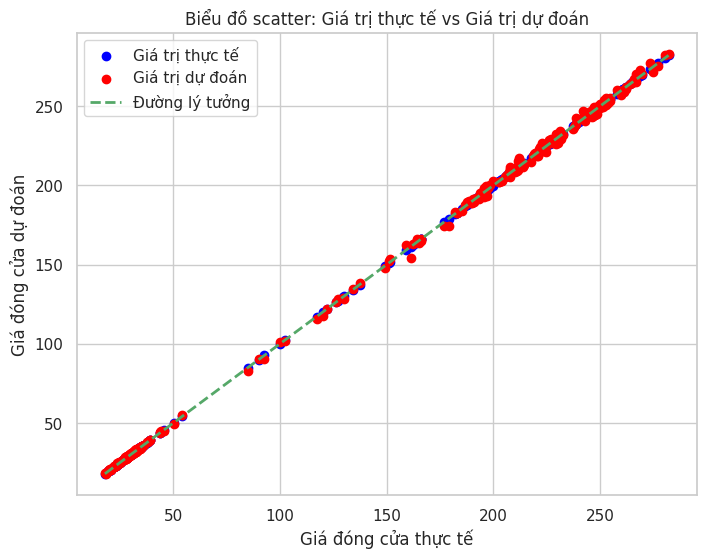

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test, color='blue', label='Giá trị thực tế')
plt.scatter(y_test, Y_pred, color='red', label='Giá trị dự đoán')
# Vẽ đường lý tưởng
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--', lw=2, label='Đường lý tưởng')
plt.xlabel('Giá đóng cửa thực tế')
plt.ylabel('Giá đóng cửa dự đoán')
plt.title('Biểu đồ scatter: Giá trị thực tế vs Giá trị dự đoán')
plt.legend()
plt.grid(True)
plt.show()


Nhìn chung, giá đóng cửa dự đoán gần như trùng khớp với giá trị thực tế. Bên cạnh đó đường hồi quy tuyến tính khớp khá tốt so với cái điểm dữ liệu thực tế, điều này cho thấy mô hình dự đoán hiệu quả

##MÔ HÌNH HỌC SÂU


###Chuẩn bị dữ liệu cho mô hình

- Trích ra những cột cần thiết từ bộ dữ liệu gốc với biến target là “Adj Close” và các biến đầi vào lần lượt sẽ là “Open”, “High”, “Low”, Volume”.
- Chuẩn hóa dữ liệu bằng cách sử dụng hàm MinmaxScaler để đưa các giá trị về khoảng [0;1].
- Hai tập train_data và test_data với X đại diện cho các đặc trưng đầu vào và Y là đại diện cho biến mục tiêu. Vòng lặp trong hàm này sẽ lấy các cửa sổ dữ liệu có kích thước bằng ‘time_shape’ và thêm chúng vào X, dữ liệu giá đóng sẽ tương ứng thêm vào Y.
- Thực hiện định hình dữ liệu đầu vào thành 3 chiều.

In [ ]:
features = df[['Open', 'High', 'Low', 'Adj Close', 'Volume']].values

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Tạo dữ liệu huấn luyện và kiểm tra
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # Chọn tất cả các cột đặc trưng
        Y.append(data[i + time_step, 3])  # Cột 3 là giá đóng cửa
    return np.array(X), np.array(Y)

# Thiết lập số bước thời gian
time_step = 30
X, Y = create_dataset(scaled_features, time_step)

# Định hình lại dữ liệu
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

###RNN


1. Huấn luyện mô hình

1.1. Khởi tạo mô hình RNN

In [ ]:
def build_model_rnn(input_shape):
    model_rnn = Sequential(name='Simple_RNN')
    model_rnn.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
    model_rnn.add(Dropout(0.2))
    model_rnn.add(SimpleRNN(50))
    model_rnn.add(Dropout(0.2))
    model_rnn.add(Dense(1))  # Chỉ dự đoán giá đóng cửa
    model_rnn.compile(optimizer='adam', loss='mean_squared_error')
    return model_rnn
# Xác định input_shape
input_shape = (X.shape[1], X.shape[2])
model_rnn= build_model_rnn(input_shape)
model_rnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_106 (SimpleRNN)           │ (None, 30, 50)              │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_206 (Dropout)                │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_107 (SimpleRNN)           │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_207 (Dropout)                │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,901 (30.86 KB)

 Trainable params: 7,901 (30.86 KB)

 Non-trainable params: 0 (0.00 B)

- Mô hình Simple RNN có 2 lớp, mỗi lớp có 50 nơ-ron ẩn, xen kẽ với 2 lớp RNN sẽ là lớp Dropout để giảm khả năng bị overfitting.
- Sử dụng hàm mất mát (loss function) là ‘mean_squared_error’ và ‘adam’ để tối ưu hóa mô hình

1.2. Huấn luyện mô hình

Sử dụng Early Stopping và Time Series Split để có thể cải thiện hiệu suất cũng như là tiết kiệm thời gian huấn luyện mô hình

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)  # Chia dữ liệu thành 5 fold
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    model_rnn = build_model_rnn(X_train.shape[1:])  # Truyền kích thước đầu vào
    model_rnn.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test),
              callbacks=[early_stopping], verbose=1)
    print("Simple_RNN Score---> ", model_rnn.evaluate(X_test, Y_test, verbose=1))


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0980 - val_loss: 0.0141
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0262 - val_loss: 0.0042
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0128 - val_loss: 9.4432e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0104 - val_loss: 0.0017
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0063 - val_loss: 6.1862e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0052 - val_loss: 9.2237e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0048 - val_loss: 4.1425e-04
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0037 - val_loss: 4.2915e-04
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0044 - val_loss: 3.1827e-04
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0035 - val_loss: 2.4222e-04
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0028 - val_loss: 2.4425e-04
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - 

Dựa trên kết quả, có sự giảm mạnh từ vòng 1 sang vòng 2 (từ 4.269 xuống 0.0599) và có sự giảm dần đều lần lượt qua các vòng còn lại. Ngoài ra, cả hai chỉ số ‘loss’ và ‘val_loss’ đều có xu hướng giảm ở mỗi vòng lặp và có sự chênh lệch nhưng không lớn. Có thể thấy mô hình RNN còn gặp một số bất cập khi tiến hành huấn luyện và có thể bị tình trạng overfitting

2. Dự đoán và đánh giá hiệu suất

2.1. Dự đoán

In [ ]:
#1. Tiến hành dự đoán
train_predict_rnn = model_rnn.predict(X_train)
test_predict_rnn = model_rnn.predict(X_test)

#2. Chuyển đổi dữ liệu về dạng gốc
train_predict_rnn_cd = scaler.inverse_transform(np.concatenate((np.zeros((train_predict_rnn.shape[0], 4)), train_predict_rnn), axis=1))[:, 4]
test_predict_rnn_cd = scaler.inverse_transform(np.concatenate((np.zeros((test_predict_rnn.shape[0], 4)), test_predict_rnn), axis=1))[:, 4]

#3. Chuyển đổi dữ liệu thực tế về dạng gốc
Y_trained = scaler.inverse_transform(np.concatenate((np.zeros((len(Y_train), 4)), Y_train.reshape(-1, 1)), axis=1))[:, 4]
Y_tested = scaler.inverse_transform(np.concatenate((np.zeros((len(Y_test), 4)), Y_test.reshape(-1, 1)), axis=1))[:, 4]

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


- Tiến hành dự đoán giá đóng điều chỉnh “Adj Close” trên cả hai tập Test set và Train set.
- Sau khi có kết quả, tiến hành chuyển đổi dữ liệu về dạng gốc.

2.2. Đánh giá hiệu suất

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# 1. Tính toán MSE và R² cho tập huấn luyện (Training Set)
mse_train = mean_squared_error(Y_train, train_predict_rnn)
r2_train = r2_score(Y_train, train_predict_rnn)

print(f"Training MSE: {mse_train}")
print(f"Training R² Score: {r2_train}")

# 2. Tính toán MSE và R² cho tập kiểm tra (Test Set)
mse_test = mean_squared_error(Y_test, test_predict_rnn)
r2_test = r2_score(Y_test, test_predict_rnn)

print(f"Test MSE: {mse_test}")
print(f"Test R² Score: {r2_test}")

Training MSE: 0.004768608091621611
Training R² Score: 0.9601351234644298
Test MSE: 0.0037852889087653255
Test R² Score: 0.5518719408046225


- Kết quả cho thấy chỉ số MSE trên cả hai tập Train và Test đều ở mức thấp, qua đó cho thấy mô hình hoạt động tốt và không có lỗi quá lớn khi dự đoán trên dữ liệu mới.
- Nhưng ở chỉ số R-squared, có sự chênh lệch đáng kể ở tập Train (0.960) và tập Test (0.5518). Điều này cho thấy mô hình hoạt động tốt trên tập Train nhưng kém trên tập Test, do vậy có sự overfitting nhẹ và khả năng tổng quát cần cải thiện thêm.

3. Trực quan hóa kết quả dự đoán

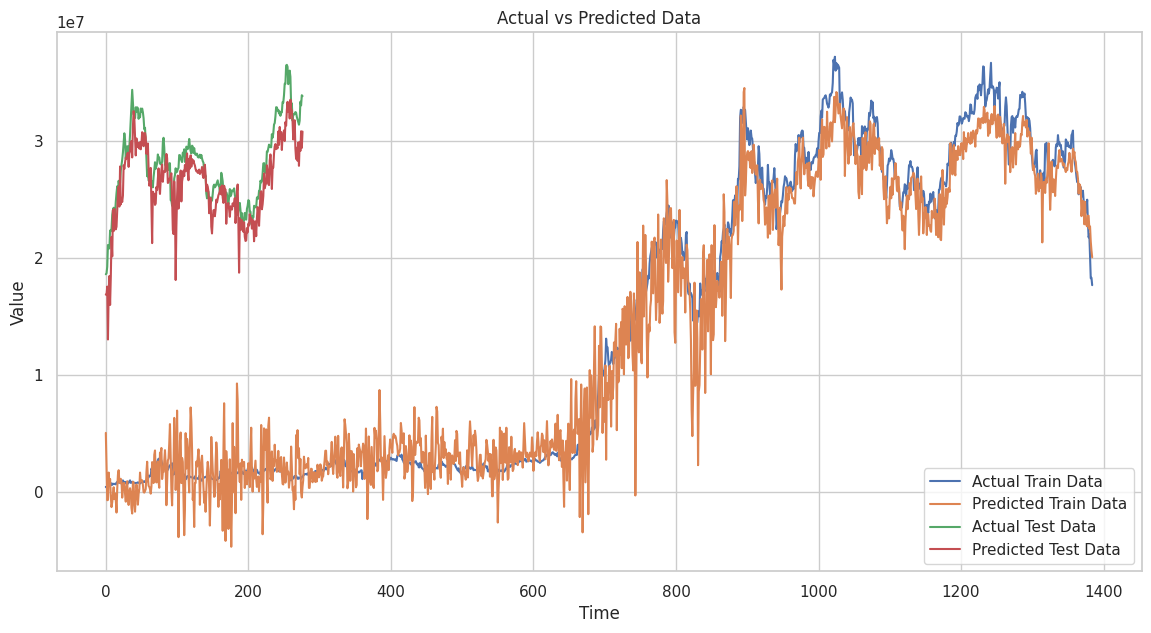

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(Y_trained, label='Actual Train Data')
plt.plot(train_predict_rnn_cd, label='Predicted Train Data')
plt.plot(Y_tested, label='Actual Test Data')
plt.plot(test_predict_rnn_cd, label='Predicted Test Data')
plt.title('Actual vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

Có thể thấy, dữ liệu gốc và dữ liệu dự đoán trên tập Train rất khớp với nhau (đường cam và đường xanh dương), cho thấy mô hình có khả năng tái tạo lại xu hướng giá trong tập huấn luyện, Tuy nhiên trên tập Test có sự khác biệt khá rõ ràng, có mức độ sai lệch cao, đặc biệt khi giá giảm hoặc tăng đột ngột.

###LSTM

1. Huấn luyện mô hình

1.1. Khởi tạo các lớp cho LSTM

In [ ]:
def build_model(input_shape):
    model_lstm = Sequential(name='LSTM')
    model_lstm.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(50))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(1))  # Chỉ dự đoán giá đóng cửa
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    return model_lstm

# Xác định input_shape
input_shape = (X.shape[1], X.shape[2])
model_lstm = build_model(input_shape)

model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_100 (LSTM)                      │ (None, 30, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_218 (Dropout)                │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_101 (LSTM)                      │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_219 (Dropout)                │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

Em đã khởi tạo mô hình LSTM với kiến trúc tương tự với mô hình RNN với phần trên, với hai lớp được xếp chồng lên nhau với số nơ-ron ẩn là 50. Và sử dụng các hàm, Dense và Dropout tương tự như RNN.

1.2. Huấn luyện mô hình

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Huấn luyện mô hình
    model_lstm = build_model(X_train.shape[1:])  # Truyền kích thước đầu vào
    model_lstm.fit(X_train, Y_train, epochs=50, batch_size=32,  validation_data=(X_test, Y_test),
              callbacks=[early_stopping], verbose=1)

    print("LSTM Score---> ", model_lstm.evaluate(X_test, Y_test, verbose=1))


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 8.8536e-04 - val_loss: 4.6610e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.3089e-04 - val_loss: 1.7057e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.5563e-04 - val_loss: 2.0815e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0758e-04 - val_loss: 1.3332e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 8.8468e-05 - val_loss: 9.8217e-05
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.9504e-05 - val_loss: 6.4509e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.0953e-05 - val_loss: 6.6699e-05
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.6696e-05 - val_loss: 4.8044e-05
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 6.1568e-05 - val_loss: 4.6183e-05
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.3174e-05 - val_loss: 1.0587e-04
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 6.9125e-05 - val_loss: 5.0662e-

- Có thể thấy, mô hình có sự giảm lỗi một cách nhanh chóng, đặc biệt là từ vòng 1 sang vòng 2 (từ 4.0719 xuống 0.0189) và giảm liên tục ở cái vòng còn lại, càng ổn định hơn. Qua đó, mô hình đã có xu hướng hội tụ tốt sau 5 vòng lặp.
- Đặc biệt, ở vòng thứ 5 chỉ số MSE đạt đến mức rất thấp (0.002) cho thấy mô hình có khả năng dự đoán khá chính xác giá trị đầu ra.
- Bên cạnh đó, so với các chỉ số MSE của mô hình RNN, có thể thấy mô hình LSTM hoạt động tốt hơn rất nhiều so với RNN.

2. Dự đoán và đánh giá hiệu suất

2.1. Tiến hành dự đoán

In [ ]:
#1. Tiến hành dự đoán
train_predict_lstm = model_lstm.predict(X_train)
test_predict_lstm = model_lstm.predict(X_test)

#2. Chuyển đổi dữ liệu về dạng gốc
train_predict_cd = scaler.inverse_transform(np.concatenate((np.zeros((train_predict_rnn.shape[0], 4)), train_predict_rnn), axis=1))[:, 4]
test_predict_cd = scaler.inverse_transform(np.concatenate((np.zeros((test_predict_rnn.shape[0], 4)), test_predict_rnn), axis=1))[:, 4]

#3. Chuyển đổi dữ liệu thực tế về dạng gốc
Y_train_cd = scaler.inverse_transform(np.concatenate((np.zeros((len(Y_train), 4)), Y_train.reshape(-1, 1)), axis=1))[:, 4]
Y_test_cd = scaler.inverse_transform(np.concatenate((np.zeros((len(Y_test), 4)), Y_test.reshape(-1, 1)), axis=1))[:, 4]


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Với mục đích có thể so sánh hai mô hình RNN và LSTM, vì vậy ở phần dự đoán và đánh giá hiệu suất này, em cũng sẽ thực hiện tương tự như mô hình RNN.

2.2, Đánh giá hiệu suất

In [ ]:

# 1. Tính toán MSE và R² cho tập huấn luyện (Training Set)
mse_train = mean_squared_error(Y_train, train_predict_lstm)
r2_train = r2_score(Y_train, train_predict_lstm)

print(f"Training MSE: {mse_train}")
print(f"Training R² Score: {r2_train}")

# 2. Tính toán MSE và R² cho tập kiểm tra (Test Set)
mse_test = mean_squared_error(Y_test, test_predict_lstm)
r2_test = r2_score(Y_test, test_predict_lstm)

print(f"Test MSE: {mse_test}")
print(f"Test R² Score: {r2_test}")

Training MSE: 0.0013393657035104555
Training R² Score: 0.9888030957083193
Test MSE: 0.002381493315729997
Test R² Score: 0.7180627415007673


Với kết quả trên, có thể thấy mô hình LSTM hoạt động rất tốt trên tập Train với độ chính xác R-squared gần như tối cao và chỉ số MSE thấp. Ở tập Test, có chỉ số R-squared giảm so với tập Train nhưng không đáng kể.

3. Trực quan hóa kết quả dự đoán

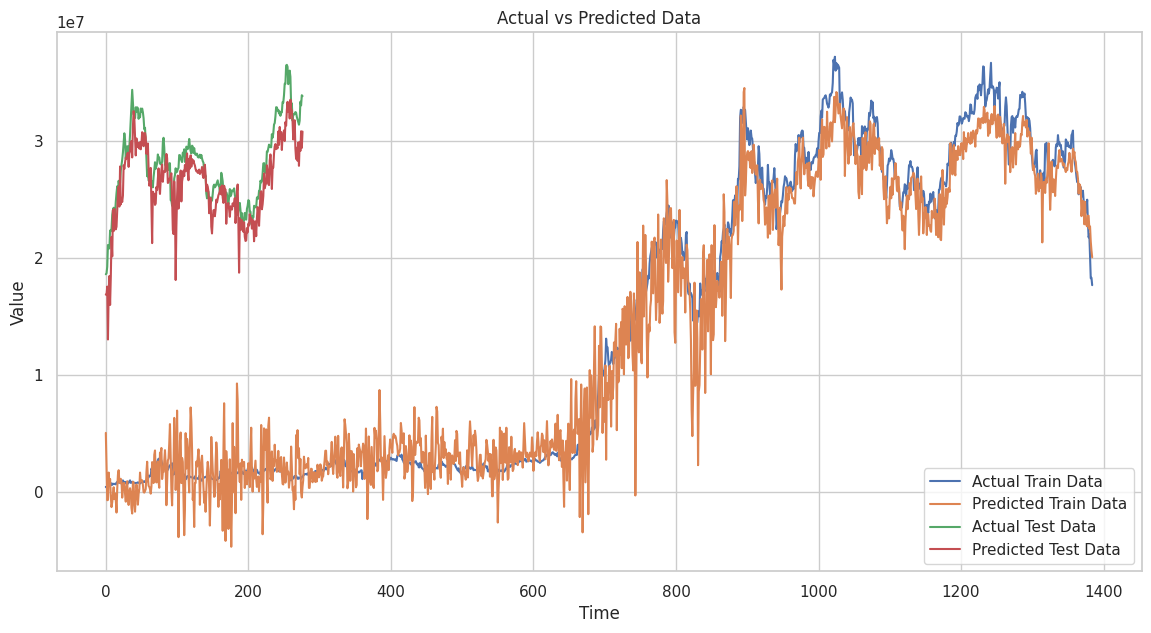

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(Y_train_cd, label='Actual Train Data')
plt.plot(train_predict_cd, label='Predicted Train Data')
plt.plot(Y_test_cd, label='Actual Test Data')
plt.plot(test_predict_cd, label='Predicted Test Data')
plt.title('Actual vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

Dữ liệu dự đoán và thực tế khá khớp nhau trên tập huấn luyện, có một vài sự sai lệch nhỏ nhưng không đáng kể. Bên cạnh đó, tại tập dữ liệu Test có một số giai đoạn biến động mạnh, nhưng nhìn chung xu hướng giá vẫn được mắm bắt